In [112]:
function sample_parameters_from_LHC(number_of_sets, number_of_parameters, gens)
    plan, _ = LatinHypercubeSampling.LHCoptim(number_of_sets, number_of_parameters, gens)
    params = LatinHypercubeSampling.scaleLHC(plan, [(0, 1) for _ in 1:number_of_parameters])
    return [params[i,:] for i in 1:number_of_sets]
end

sample_parameters_from_LHC (generic function with 1 method)

In [113]:
include("CRNevo.jl")
include("CRNExplore.jl")
include("SymbolicOps.jl")
eval(Meta.parse("@variables " * join([ifelse(i==3 && j==80, "", "ks_" * string(i) * "_" * string(j) *"(t), ") for i in 1:3 for j in 1:80]) * "ks_" * string(3) * "_" * string(80) * "(t)"))
include("CRNevo.jl")
include("CRNExplore.jl")
include("SymbolicOps.jl")

# --- GA parameters
genetic_pool_size = 1000

death_rate = (rank) -> (5/100)*(rank)
mutation_rate = (rank) -> (25/100)
gradient_mutation_rate = (rank) -> (1/1000)*(1-rank)
duplication_rate = (rank) -> (20/100)*(1-rank)
crossover_rate = (rank) -> 0.0*(1-rank)
max_generations = 100
p_cross = 0.1

# --- GD parameters

# fixed, basic steps

N = 3
np = count_parameters(N)
target = N
crn = create_reactions(N)
ode_crn = convert(ODESystem, crn)
pars_l = assemble_opt_parameters_and_varables([0 for _ in 1:np], N) # just for the names
ext_ode = make_sensitivity_ode(ode_crn, pars_l.p)
t0 = 10.0
t1 = 20.0

# set up gd problem 

crn_info = (
    crn = crn, 
    ode_crn = ode_crn,
    ext_ode = ext_ode,
    np = np,
    N = N,
    target = target
)

# set up the loss function

gd_loss_options = (
    weights = [1., 10., 1.0/80, 1.], #[2.0, 1.0/3, 1.0/80, 100.0], #[1., 0.01, 0.01, 1.] # this descends smoothly
    p=0.05,
    d=0.5,
    f_ss=0.5,
    norm_for_sensitivity_loss = 1, 
    norm_for_ss_loss = 1,
    norm_for_adaptation_loss = 1,
    n_losses = 4
)

loss_blueprint = prepare_args(nothing, target, t0, t1, pars_l, gd_loss_options.weights, gd_loss_options.p, gd_loss_options.d, gd_loss_options.f_ss, gd_loss_options.norm_for_sensitivity_loss, gd_loss_options.norm_for_ss_loss, gd_loss_options.norm_for_adaptation_loss)

gd_options = (
    alpha = 0.1,
    n_iter = 10,
    use_pruning_heuristic = false,
    clip_value = nothing,
    use_gradient_normalization = false,
    use_adagrad = true, # overrides use_adam!
    use_adam = false,
    use_random_perturbation = false,
    verbose = false,
    # placed here for convenience, should be in gd_loss_options
    symbolic_derivatives_of_loss = compute_symbolic_derivatives_of_loss(total_loss_symbolic(loss_blueprint))
)

gd_perturbation_options = (
    t0 = t0,
    t1 = t1,
    input = 1.,
    perturbation = 1.,
    K = 5,
    perturbation_list = [-1., -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1., 2., 3., 4., 5.],
    loss_blueprint = loss_blueprint
)


mutate_with_GD = (p) -> symbolic_gradient_descent(p, crn_info, gd_options, gd_perturbation_options, gd_loss_options).parameters
function make_ev_loss(crn_info, gd_options, gd_perturbation_options, gd_loss_options, with_L1)
    function ev_loss(p)
        pars_l = assemble_opt_parameters_and_varables(p, crn_info.N)
        solutions = run_with_fixed_perturbations(crn_info.crn, p, pars_l, gd_perturbation_options.input,  gd_perturbation_options.perturbation_list, gd_perturbation_options.t0, gd_perturbation_options.t1)
        losses = zeros(length(solutions))
        Threads.@threads for i in 1:length(solutions)
            loss_args = update_args(solutions[i], crn_info.target, gd_perturbation_options.t0, gd_perturbation_options.t1, pars_l, gd_perturbation_options.loss_blueprint, gd_loss_options.p, gd_loss_options.d, gd_loss_options.f_ss) 
            if with_L1
                losses[i] = total_loss_eval(loss_args).total.val
            else
                ev = total_loss_eval(loss_args)
                losses[i] = ev.total.val - ev.array[3].val
            end
        end
        return sum(losses)/length(gd_perturbation_options.perturbation_list)
    end
    return ev_loss
end
#loss_function_gd = make_ev_loss(crn_info, gd_options, gd_perturbation_options, gd_loss_options, true)
loss_function_ga = make_ev_loss(crn_info, gd_options, gd_perturbation_options, gd_loss_options, true)
print("setup done!")

setup done!

In [114]:
import LatinHypercubeSampling
# plan, _ = LatinHypercubeSampling.LHCoptim(100, 2, 100)
# scaled_plan = LatinHypercubeSampling.scaleLHC(plan, [(0, 1) for _ in 1:2])
# plot(scaled_plan[:,1], scaled_plan[:,2], seriestype = :scatter, legend = false, title = "Latin Hypercube Sampling")

In [115]:
#reactions(crn)[30] # so we want to edit only parameter 29

In [116]:
# unused
# output_degradation_parameter = 29
# minimal_degradation_rate = 0.1

In [117]:
# println("Testing symbolic gradient descent")
# println(loss_function([1 for _ in 1:np]))
# test_p = symbolic_gradient_descent([1 for _ in 1:np], crn_info, gd_options, gd_perturbation_options, gd_loss_options)
# println(loss_function(test_p.parameters))

initialize the GA problem 

In [118]:
parameter_pool = sample_parameters_from_LHC(genetic_pool_size, np, 10) #[[rand() for _ in 1:np] for _ in 1:genetic_pool_size]
is_updated = [false for _ in 1:genetic_pool_size]
fitness = [0. for _ in 1:genetic_pool_size]

dp = 0.05

state = (pool = parameter_pool, is_updated = is_updated, fitness = fitness, history = (best_loss = [], mean_loss = []))
print("done")

done

In [119]:
using ProgressBars
max_generations = 500
for i in ProgressBar(1:max_generations)
    state = symbolic_evolve_NFB(crn, loss_function_ga, state, dp, genetic_pool_size, death_rate, mutation_rate, gradient_mutation_rate, mutate_with_GD, duplication_rate, crossover_rate, p_cross)
end

0.0%┣                                              ┫ 0/500 [00:00<00:00, -0s/it]
0.2%┣                                          ┫ 1/500 [01:15<Inf:Inf, InfGs/it]
0.4%┣▏                                         ┫ 2/500 [01:59<16:30:36, 119s/it]
0.6%┣▎                                          ┫ 3/500 [02:24<09:56:13, 72s/it]
0.8%┣▍                                          ┫ 4/500 [02:47<07:40:13, 56s/it]
1.0%┣▍                                          ┫ 5/500 [03:10<06:32:12, 48s/it]
1.2%┣▌                                          ┫ 6/500 [03:34<05:52:59, 43s/it]
1.4%┣▋                                          ┫ 7/500 [03:59<05:26:46, 40s/it]
1.6%┣▊                                          ┫ 8/500 [04:37<05:24:30, 40s/it]
1.8%┣▊                                          ┫ 9/500 [05:16<05:23:35, 40s/it]
2.0%┣▉                                         ┫ 10/500 [05:42<05:10:28, 38s/it]
2.2%┣█                                         ┫ 11/500 [06:07<04:58:59, 37s/it]
2.4%┣█                      

In [120]:
minimum(state.history.mean_loss)

0.21582986039159774

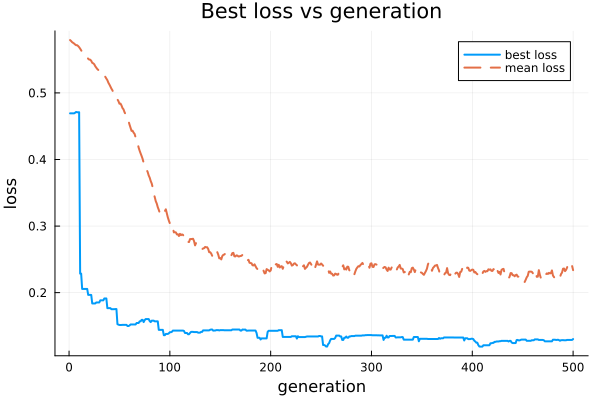

In [121]:
plot(state.history.best_loss, label="best loss", xlabel="generation", ylabel="loss", title="Best loss vs generation", lw=2, legend=:topright)
plot!(state.history.mean_loss, label="mean loss", lw=2, line=:dash)

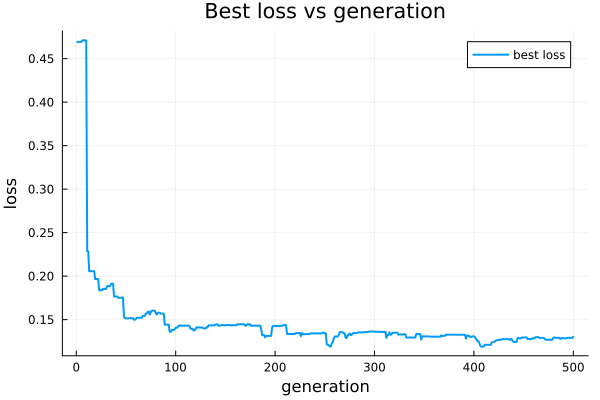

In [122]:
plot(state.history.best_loss, label="best loss", xlabel="generation", ylabel="loss", title="Best loss vs generation", lw=2, legend=:topright)

In [123]:
best = argmin(state.fitness)
println("Best loss: ", state.fitness[best])

Best loss: 0.1303040695997981


Optimal index: 395
Adaptation error: 0.0029223645396071474
sensitivity: 0.018905641189975286 and  loss : 0.008905641189975286


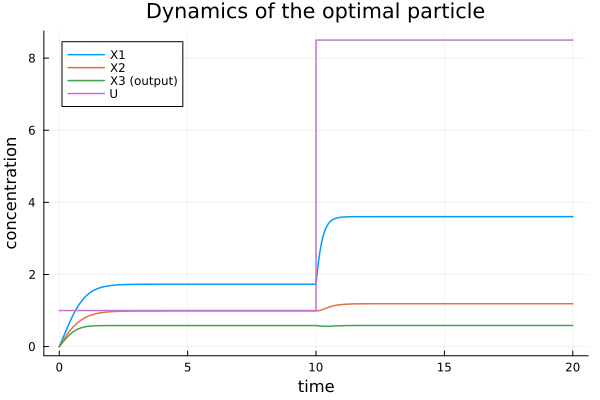

In [157]:
perturb = 7.5
opt_index = sortperm(state.fitness)[4]

opt_pars_v = state.pool[opt_index]
opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

sol = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1]
println("Optimal index: ", opt_index)
println("Adaptation error: ", abs(sol(t0)[3] - sol(t1)[3]))
println("sensitivity: ", abs(sol(t0)[3] - sol(t0+0.5)[3]), " and  loss : ", abs(abs(sol(t0)[3] - sol(t0+0.5)[3]) - 0.01))
plot(sol.t, vec2mat(sol.u)[:,1:4], label=["X1" "X2" "X3 (output)" "U"], lw=1.5, title="Dynamics of the optimal particle", xlabel="time", ylabel="concentration")

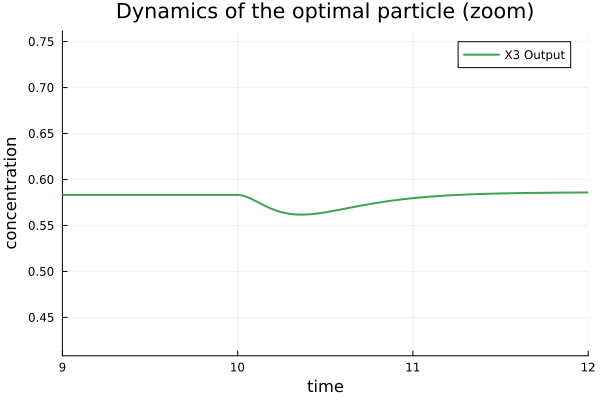

In [158]:
# zoom on reaction 3
plot(sol.t, vec2mat(sol.u)[:,3], label="X3 Output", xlabel="time", ylabel="concentration", title="Dynamics of the optimal particle (zoom)", lw=2, color=3)
xlims!(t0-1., t0+2)
ylims!(sol(t0-1)[3]-sol(t0-1)[3]*0.3, sol(t0+2)[3]+sol(t0+2)[3]*0.3)

In [126]:
gd_options_for_output = (
    alpha = gd_options.alpha/10,
    n_iter = 1000, #gd_options.n_iter,
    use_pruning_heuristic = gd_options.use_pruning_heuristic,
    clip_value = gd_options.clip_value,
    use_gradient_normalization = gd_options.use_gradient_normalization,
    use_adagrad = gd_options.use_adagrad, # overrides use_adam!
    use_adam = gd_options.use_adam,
    use_random_perturbation = gd_options.use_random_perturbation,
    verbose = true,
    # placed here for convenience, should be in gd_loss_options
    symbolic_derivatives_of_loss = gd_options.symbolic_derivatives_of_loss
)
out = symbolic_gradient_descent(state.pool[best], crn_info, gd_options_for_output, gd_perturbation_options, gd_loss_options)

(parameters = [0.0, 0.0005256995461005491, 0.0, 0.2443971185728917, 0.7486118585705835, 0.0, 0.0, 0.0005716109427464538, 0.0005503217056989663, 0.0  …  0.5870494411707106, 0.07381988329044345, 0.0005736709551555007, 0.017293417882572753, 0.0005514019140828894, 0.0, 7.569957826266142e-5, 0.0, 0.10990884621790091, 0.0], loss_tape = Any[0.13344075765651145, 0.13776290221564993, 0.1285488628343834, 0.12694463067691505, 0.12388807010822402, 0.12403470709428967, 0.12400200359352025, 0.12490772853044875, 0.12308158769325873, 0.12097000511536841  …  0.09154859448687573, 0.09223953437315685, 0.09236196961021768, 0.09136701218916511, 0.09149828304852907, 0.09213856090009004, 0.09186151217078874, 0.09177348577584314, 0.09136801609931477, 0.09227401018957293], loss_tape_array = Any[Num[0.041733288348352715, 0.0005429560000571229, 0.07893396403622596, 0.012230549271875687], Num[0.039526625495123, 0.0011059032037505356, 0.0800330772113942, 0.017097296305382193], Num[0.044694722518254355, 0.000538921

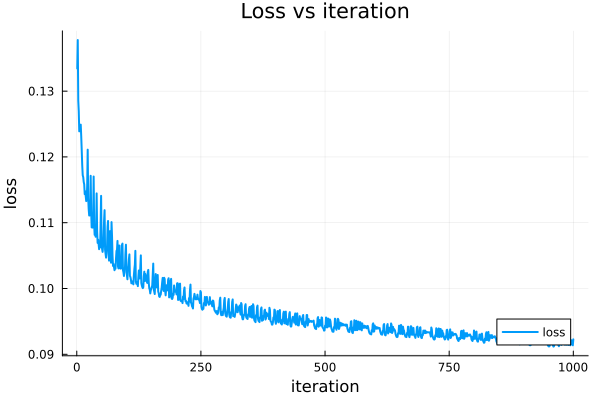

In [127]:
plot(1:length(out.loss_tape), out.loss_tape, label="loss", xlabel="iteration", ylabel="loss", title="Loss vs iteration", lw=2, legend=:bottomright)

Optimal index: 348
Adaptation error: 0.003324351340279974
sensitivity: 0.01619152043826999 and  loss : 0.0061915204382699904


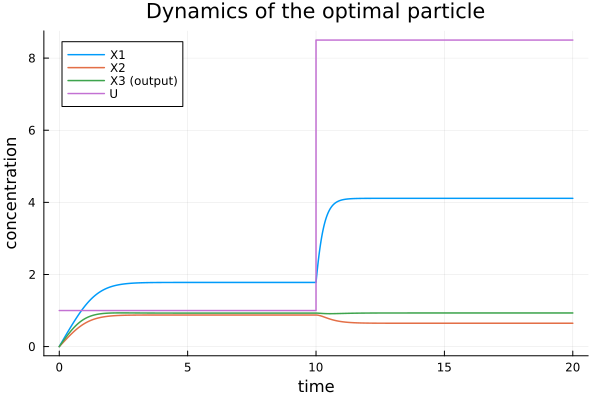

In [165]:
perturb = 7.5

gd_pars_v = out.parameter_tape[end]
gd_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

sol = run_extended_with_fixed_perturbations(ext_ode, gd_pars_l, 1., [ perturb ], t0, t1)[1]
println("Optimal index: ", opt_index)
println("Adaptation error: ", abs(sol(t0)[3] - sol(t1)[3]))
println("sensitivity: ", abs(sol(t0)[3] - sol(t0+0.5)[3]), " and  loss : ", abs(abs(sol(t0)[3] - sol(t0+0.5)[3]) - 0.01))
plot(sol.t, vec2mat(sol.u)[:,1:4], label=["X1" "X2" "X3 (output)" "U"], lw=1.5, title="Dynamics of the optimal particle", xlabel="time", ylabel="concentration")

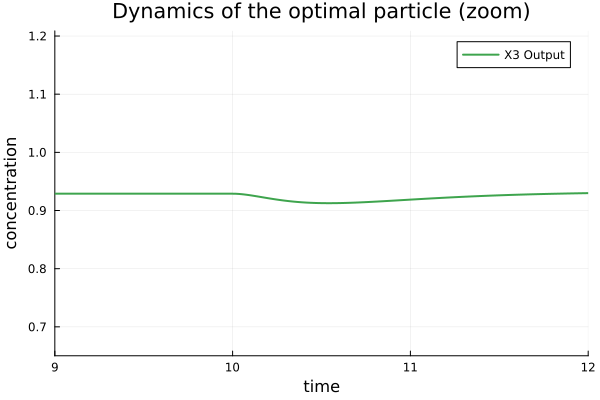

In [166]:
# zoom on reaction 3
plot(sol.t, vec2mat(sol.u)[:,3], label="X3 Output", xlabel="time", ylabel="concentration", title="Dynamics of the optimal particle (zoom)", lw=2, color=3)
xlims!(t0-1., t0+2)
ylims!(sol(t0-1)[3]-sol(t0-1)[3]*0.3, sol(t0+2)[3]+sol(t0+2)[3]*0.3)

In [162]:
using Symbolics
using LinearAlgebra
function joint_jacobian(i, j, jac, initial_conditions)
    A_ij = substitute(jac[i, j], unsym_dict(initial_conditions))
    return A_ij
end

opt_index = sortperm(state.fitness)[2]

opt_pars_v = out.parameter_tape[end]
opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

jac = Symbolics.substitute(calculate_jacobian(ode_crn), unsym_dict(opt_pars_l.p))

perturb = 7.5
steady_state_after_perturbation = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1](t1)[1:3]
steady_state_after_perturbation = [
    :x_1 => steady_state_after_perturbation[1],
    :x_2 => steady_state_after_perturbation[2],
    :x_3 => steady_state_after_perturbation[3]
]

A_21 = joint_jacobian(2, 1, jac, steady_state_after_perturbation)
A_32 = joint_jacobian(3, 2, jac, steady_state_after_perturbation)
A_22 = joint_jacobian(2, 2, jac, steady_state_after_perturbation)
A_31 = joint_jacobian(3, 1, jac, steady_state_after_perturbation)

println("A_21 = ", A_21)
println("A_32 = ", A_32)
println("A_22 = ", A_22)
println("A_31 = ", A_31)
println("A_22*A_31 = ", A_22*A_31)
println("A_21*A_32 = ", A_21*A_32)
println("A_22*A_31 - A_21*A_32 = ", A_22*A_31 - A_21*A_32)

A_21 = -0.1363171294663323
A_32 = -0.4054115653296566
A_22 = -2.3761891872196186
A_31 = 0.01676136146486118
A_22*A_31 = -0.03982816587588272
A_21*A_32 = 0.05526454083819123
A_22*A_31 - A_21*A_32 = -0.09509270671407395


In [131]:
homeostatic_coefs_A21_A32 = []
homeostatic_coefs_A22_A31 = []
homeostatic_coefs = []

for par_set in state.pool
    opt_pars_v = par_set
    opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

    jac = Symbolics.substitute(calculate_jacobian(ode_crn), unsym_dict(opt_pars_l.p))

    perturb = 2.5
    steady_state_after_perturbation = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1](t1)[1:3]
    steady_state_after_perturbation = [
        :x_1 => steady_state_after_perturbation[1],
        :x_2 => steady_state_after_perturbation[2],
        :x_3 => steady_state_after_perturbation[3]
    ]

    A_21 = joint_jacobian(2, 1, jac, steady_state_after_perturbation)
    A_32 = joint_jacobian(3, 2, jac, steady_state_after_perturbation)
    A_22 = joint_jacobian(2, 2, jac, steady_state_after_perturbation)
    A_31 = joint_jacobian(3, 1, jac, steady_state_after_perturbation)

    push!(homeostatic_coefs_A21_A32, A_21*A_32)
    push!(homeostatic_coefs_A22_A31, A_22*A_31)
    push!(homeostatic_coefs, A_22*A_31 - A_21*A_32)
end

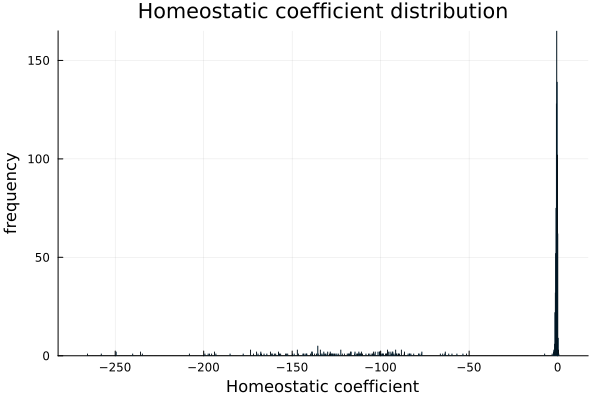

In [132]:
histogram([x.val for x in homeostatic_coefs], label=false, xlabel="Homeostatic coefficient", ylabel="frequency", title="Homeostatic coefficient distribution", lw=0.5, legend=:bottomright)

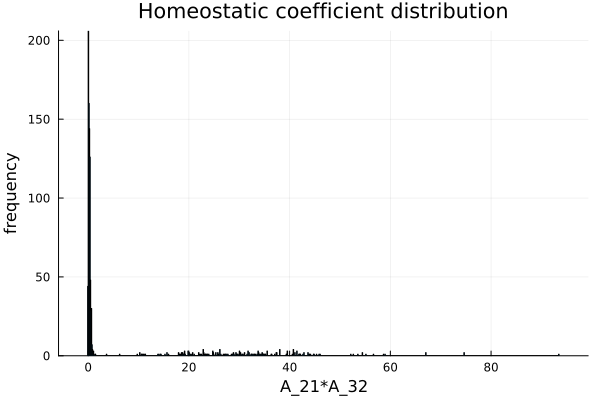

In [133]:
histogram([x.val for x in homeostatic_coefs_A21_A32], label=false, xlabel="A_21*A_32", ylabel="frequency", title="Homeostatic coefficient distribution", lw=1, legend=:bottomright)

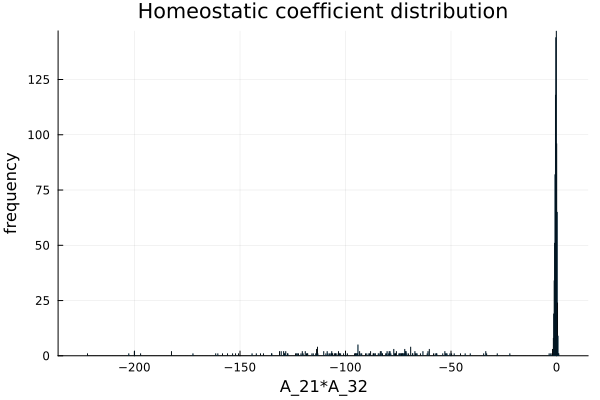

In [134]:
histogram([x.val for x in homeostatic_coefs_A22_A31], label=false, xlabel="A_21*A_32", ylabel="frequency", title="Homeostatic coefficient distribution", lw=0.5, legend=:bottomright)

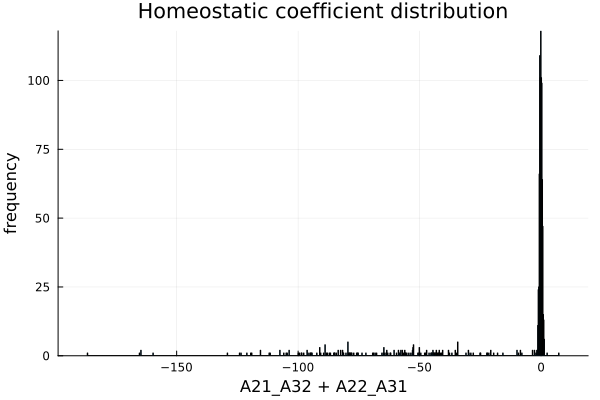

In [135]:
histogram([ x.val for x in homeostatic_coefs_A21_A32 + homeostatic_coefs_A22_A31], xlabel="A21_A32 + A22_A31", ylabel="frequency", title="Homeostatic coefficient distribution", lw=1, legend=false)

In [173]:
using Pkg; Pkg.add("LaTeXStrings")

   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
  [b964fa9f] + LaTeXStrings v1.3.1
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [174]:
using LaTeXStrings

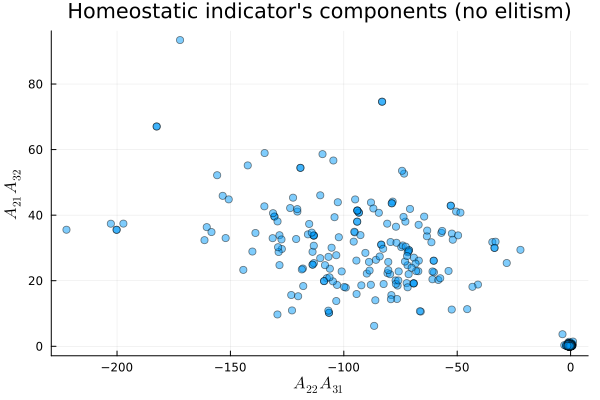

In [181]:
plot([x.val for x in homeostatic_coefs_A22_A31], [x.val for x in homeostatic_coefs_A21_A32], seriestype = :scatter, xlabel=L"A_{22}A_{31}", ylabel=L"A_{21}A_{32}", title="Homeostatic indicator's components (no elitism)", lw=2, legend=false, alpha=0.5)


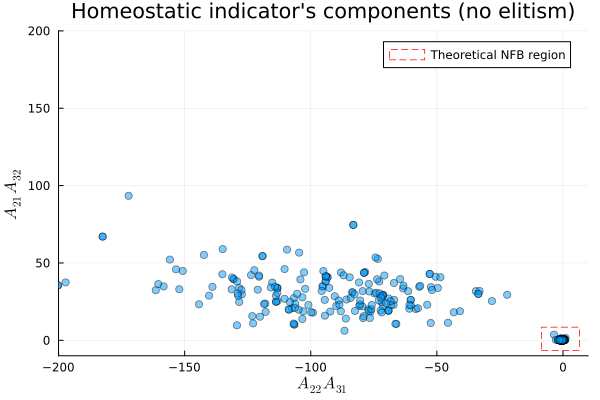

In [215]:
plot([x.val for x in homeostatic_coefs_A22_A31], [x.val for x in homeostatic_coefs_A21_A32], label=false, seriestype = :scatter, xlabel=L"A_{22}A_{31}", ylabel=L"A_{21}A_{32}", title="Homeostatic indicator's components (no elitism)", lw=2, legend=false, alpha=0.5)
xlims!(-200, 10)
ylims!(-10, 200)
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
plot!([rectangle(15, 15, -8.5, -6.5)], color=RGBA{Float64}(1, 1, 1, 0), linecolor=:red, lw=0.75, linestyle=:dash, label="Theoretical NFB region", legend=:topright)

In [216]:
savefig(plot!(),"homeostatic_indicator_NFB.svg")

"/local0/scratch/git/SynthEvo/homeostatic_indicator_NFB.svg"

Adapting toplogies

In [137]:
findall(x -> -0.5 < x < 0.5, [x.val for x in homeostatic_coefs])

392-element Vector{Int64}:
   2
   3
   7
   8
   9
  18
  19
  21
  22
  25
  31
  32
  36
   ⋮
 966
 970
 971
 975
 983
 984
 987
 990
 991
 993
 995
 997

IFF

NFB

In [138]:
findall(x -> 0.01 < x < 0.1, (abs.([x.val for x in homeostatic_coefs_A22_A31]) + abs.([x.val for x in homeostatic_coefs_A21_A32]))/2  )

56-element Vector{Int64}:
   2
  32
  42
  50
  72
  76
  95
 105
 129
 167
 189
 190
 195
   ⋮
 732
 767
 817
 818
 826
 838
 843
 891
 899
 911
 914
 997

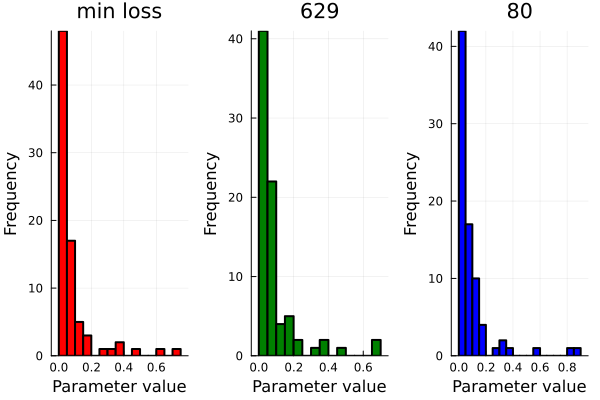

In [139]:

opt_index_options = [best, rand(1:length(state.pool)), 80]
opt_index_options_labels = ["min loss", "$(opt_index_options[2])", "80"]
opt_index_options_colors = [:red, :green, :blue]

hists = []
for i in 1:length(opt_index_options)
    opt_index = opt_index_options[i]
    opt_pars_v = state.pool[opt_index]
    opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, 3)
    h = histogram(opt_pars_v, label=opt_index_options_labels[i], xlabel="Parameter value", ylabel="Frequency", title=opt_index_options_labels[i], lw=2, legend=false, color=opt_index_options_colors[i], bins=20)
    push!(hists, h)
end
plot(hists..., layout=(1,3))

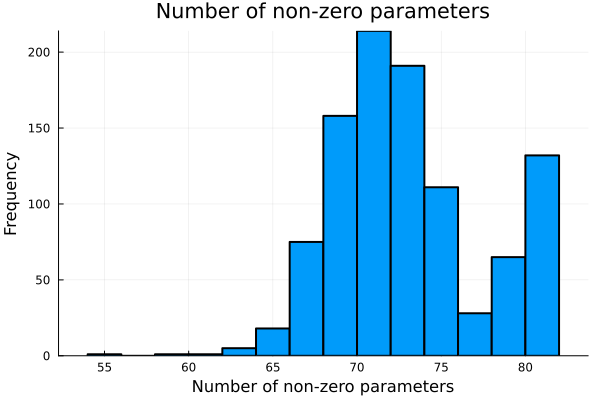

In [140]:
non_zero = []
for i in 1:length(state.fitness)
    push!(non_zero, sum(state.pool[i] .> 0.001))
end
histogram(non_zero, label=false, xlabel="Number of non-zero parameters", ylabel="Frequency", title="Number of non-zero parameters", lw=2, legend=false)

In [141]:
using JLD2

save_object("IFF-finding-run-32124-last.jld2", Dict(
    "state" => state,
    # all parameters 
    "ga_options" => Dict(
        genetic_pool_size => genetic_pool_size,
        death_rate => death_rate,
        mutation_rate => mutation_rate,
        gradient_mutation_rate => gradient_mutation_rate,
        duplication_rate => duplication_rate,
        crossover_rate => crossover_rate,
        max_generations => max_generations,
        p_cross => p_cross
    ),
    "crn_info" => crn_info,
    "gd_loss_options" => gd_loss_options,
    "gd_options" => gd_options,
    "gd_perturbation_options" => gd_perturbation_options
))    


In [142]:
# using JLD2
# test_load = load_object("/local0/scratch/git/SynthEvo/NFB-finding-run-240.jld2") 

In [143]:
# test_load["state"].fitness

In [144]:
# perturb = -1
# opt_index =  sortperm(test_load["state"].fitness)[3]
# #opt_index = 81

# opt_pars_v = test_load["state"].pool[opt_index]
# #opt_pars_v[29] = 1.0
# opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)


# sol = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1]
# println("Index: ", opt_index)
# println("Adaptation error: ", abs(sol(t0)[3] - sol(t1)[3]))
# println("sensitivity: ", abs(sol(t0)[3] - sol(t0+0.5)[3]), " and  loss : ", abs(abs(sol(t0)[3] - sol(t0+0.5)[3]) - 0.01))
# println("Loss: ", test_load["state"].fitness[opt_index])
# plot(sol.t, vec2mat(sol.u)[:,1:4], label=["X1" "X2" "X3 (output)" "U"], lw=1.5, title="Dynamics of the optimal particle", xlabel="time", ylabel="concentration")

In [145]:
# #opt_index = argmin(test_load["state"].fitness) 
# ranks = reverse(sortperm(abs.(test_load["state"].pool[opt_index])))

# for i in ranks
#     if i != 1
#         println(test_load["state"].pool[opt_index][i], " : ", reactions(crn)[2:end][i])
#     end
# end

In [218]:
out.parameter_tape[end]

80-element Vector{Float64}:
 0.0
 0.0005256995461005491
 0.0
 0.2443971185728917
 0.7486118585705835
 0.0
 0.0
 0.0005716109427464538
 0.0005503217056989663
 0.0
 0.02647814337252125
 0.0
 0.004230223308169452
 ⋮
 0.0005687241124145136
 0.0006124721729845811
 0.5870494411707106
 0.07381988329044345
 0.0005736709551555007
 0.017293417882572753
 0.0005514019140828894
 0.0
 7.569957826266142e-5
 0.0
 0.10990884621790091
 0.0

In [220]:
ranks = reverse(sortperm(abs.(out.parameter_tape[end])))

filter = 0.001

for i in ranks
    if i != 1
        if abs(out.parameter_tape[end][i]) > filter
            println(out.parameter_tape[end][i], " : ", reactions(crn)[2:end][i])
        end
    end
end

0.7486118585705835 : k_5, ∅ --> x_2 + x_3
0.5870494411707106 : k_71, x_2 + x_3 --> 2*x_1
0.41950995013015757 : k_30, 2*x_1 --> ∅
0.3104946310912284 : k_31, x_1 + x_2 --> ∅
0.2554787822928285 : k_32, x_1 + x_3 --> ∅
0.2443971185728917 : k_4, ∅ --> x_1 + x_3
0.17052450330643887 : k_61, x_1 + x_3 --> 2*x_1
0.10990884621790091 : k_79, 2*x_3 --> 2*x_2
0.07775889047531676 : k_38, x_1 + x_2 --> x_1
0.07597108925414063 : k_16, x_1 --> 2*x_3
0.07381988329044345 : k_72, x_2 + x_3 --> x_1 + x_2
0.0630594368719693 : k_25, x_3 --> 2*x_2
0.058244979536552825 : k_17, x_2 --> 2*x_1
0.049730139683381615 : k_66, 2*x_2 --> 2*x_1
0.03945769382594729 : k_15, x_1 --> x_2 + x_3
0.026530700684659486 : k_60, x_1 + x_2 --> 2*x_3
0.02647814337252125 : k_11, x_3 --> x_2
0.025055395873262897 : k_42, x_1 + x_3 --> x_2
0.022497672847300004 : k_55, 2*x_1 --> 2*x_3
0.017293417882572753 : k_74, x_2 + x_3 --> 2*x_2
0.015877249721103135 : k_63, x_1 + x_3 --> 2*x_2
0.0156691740521356 : k_14, x_1 --> 2*x_2
0.01049686846611

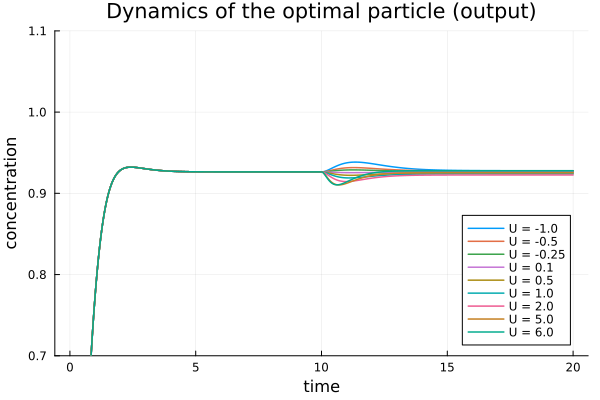

In [238]:
inputs = [-1, -0.5, -0.25, 0.1, 0.5, 1.0, 2.0, 5.0, 6.0]

filter = 0.001

pars_out_l = assemble_opt_parameters_and_varables(out.parameter_tape[end].*(out.parameter_tape[end] .> filter), N)
solutions = run_with_fixed_perturbations(crn, out.parameter_tape[end].*(out.parameter_tape[end] .> filter), pars_out_l, 1., inputs, t0, t1)

plot()
for i in 1:length(solutions)
    plot!(solutions[i].t, vec2mat(solutions[i].u)[:,3], label="U = $(inputs[i])", lw=1.5, title="Dynamics of the optimal particle (output)", xlabel="time", ylabel="concentration", legend=:bottomright)
end
plot!()
ylims!(0.7, 1.1)